# Model

## Weights

In [ ]:
import torch
from utils.models.ghostnetv2 import (
    ghostnetv2,
    SegmentationHeadGhostBN,
    GhostNetSS,
    load_fi_weights,
)
from utils.utils import get_parser, parse_args

parser, config_parser = get_parser()
args = parse_args(parser, config_parser, args="", verbose=False)

# Define the model
backbone = ghostnetv2(args)

x = torch.randn(1, 5, 512, 512)
(y, fwargs), intermediates = backbone(x)
print(y.shape)
print([inter.shape for inter in intermediates])
print(fwargs)

In [ ]:
head = SegmentationHeadGhostBN(args)
model = GhostNetSS(backbone, head, args)

In [ ]:
l_model = [l for l in model.state_dict().keys() if "dummy" not in l]
l_weights = list(torch.load("ckpt/bb_heads_clouds.pth", weights_only=True).keys())

In [ ]:
len(l_model), len(l_weights)

In [ ]:
list(zip(l_model, l_weights))

In [ ]:
model = load_fi_weights(model, "ckpt/bb_heads_clouds.pth").cuda()

## Layer Info

In [ ]:
%load_ext autoreload
%autoreload 2

import csv
import torch
import pytorch_lightning as pl

# from pytorchfi import core as pfi_core

from utils.utils import get_parser, parse_args, build_model
from utils.data.data_module import CoreDataModule
from utils.models.LightningModelWrapper import ModelWrapper

torch.set_float32_matmul_precision("high")
pl.seed_everything(0, workers=True)
torch.backends.cudnn.benchmark = True

parser, config_parser = get_parser()
args = parse_args(parser, config_parser, args="", verbose=False)

In [ ]:
# Define the datamodule
datamodule = CoreDataModule(args)

# Define the model
net = build_model(args)
net = net.cuda().eval()

model = ModelWrapper(model=net, args=args)

Blocks (12 to toggle): 
* ConvBnAct ✅
* 9 Blocks ✅ ( consisting of 16 GhostBottleneckV2 sub-blocks) ❌
* ConvBnAct ✅
* AdaptiveAvgPool2d ❌
* ConvAct ✅
* Linear ❌


Block Types (2 to toggle):
* Conv2d ✅
* BatchNorm2d ✅
* Linear ❌

inject_index (259 in total):
* 137 Conv2d ✅
* 122 BatchNorm2d ✅

In [ ]:
inj_layers = []
idx = 0
for i, (name, desc) in enumerate(model.model.named_modules()):
    n = name
    t = str(type(desc)).split(".")[-1].split("'")[0]
    if t in ["Conv2d", "BatchNorm2d", "Linear"]:
        inj_layers.append((idx, t, i, n))
        idx += 1

In [ ]:
csv.writer(open(f"cfg/{args.name}_layers_info.csv", mode="w")).writerows(inj_layers)

## Check Predictions

In [ ]:
import matplotlib.pyplot as plt

from utils.data.data_module import CoreDataModule
from utils.utils import build_model, get_parser, parse_args

In [ ]:
parser, config_parser = get_parser()
args = parse_args(parser, config_parser, args="", verbose=False)
args.batch_size = 4

datamodule = CoreDataModule(args)
net = build_model(args)
net = net.eval()  # .cuda()

### Check Injection

In [ ]:
for _, batch in enumerate(datamodule.val_dataloader()):
    # batch = [b.cuda() for b in batch]
    noisy, clean = net.validation_step(batch, inject_index=args.inject_index)
    if clean["loss"].detach().cpu().numpy() != noisy["loss"].detach().cpu().numpy():
        print(
            clean["loss"].detach().cpu().numpy(),
            clean["acc"],
            clean["miou"],
            clean["bacc"],
        )
        print(
            noisy["loss"].detach().cpu().numpy(),
            noisy["acc"],
            noisy["miou"],
            noisy["bacc"],
            end="\n\n",
        )
    break

In [ ]:
plt.imshow(clean["y"][0].detach().cpu().numpy().squeeze(), vmin=0, vmax=2)
print(clean["y"][0].detach().cpu().squeeze().unique())
plt.show()

plt.imshow(clean["preds"][0].detach().cpu().numpy().squeeze(), vmin=0, vmax=2)
print(clean["preds"][0].detach().cpu().squeeze().unique())
plt.show()

plt.imshow(noisy["preds"][0].detach().cpu().numpy().squeeze(), vmin=0, vmax=2)
print(noisy["preds"][0].detach().cpu().squeeze().unique())
plt.show()

### Check Metrics

In [ ]:
# V1
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import MulticlassAccuracy

v1_miou = MeanIoU(
    num_classes=args.num_classes, input_format="index", include_background=True
)  # include_background=False -> ignore index 0
v1_acc = MulticlassAccuracy(
    num_classes=args.num_classes, average="micro"
)  # macro -> balanced accuracy

# V2
from utils.segmentation.stream_metrics import StreamSegMetrics

v2_metrics = StreamSegMetrics(args.num_classes, ignore_index=None)
v2n_metrics = StreamSegMetrics(args.num_classes, ignore_index=None)

# V3
import torch
from utils.models.LightningModelWrapper import iouCalc

v3_miou = iouCalc(validClasses=range(args.num_classes))
v3n_miou = iouCalc(validClasses=range(args.num_classes))

In [ ]:
for _, batch in enumerate(datamodule.val_dataloader()):
    # batch = [b.cuda() for b in batch]
    noisy, clean = net.validation_step(batch, inject_index=args.inject_index)
    y = clean["y"]
    probs, preds = clean["probs"], clean["preds"]
    n_probs, n_preds = noisy["probs"], noisy["preds"]

    # V1
    v1, v1n = {}, {}
    v1["acc"] = v1_acc(preds, y)
    v1["miou"] = v1_miou(preds, y)
    v1n["acc"] = v1_acc(n_preds, y)
    v1n["miou"] = v1_miou(n_preds, y)
    # V2
    v2, v2n = {}, {}
    v2_metrics.update(y.cpu().numpy(), preds.cpu().numpy())
    v2n_metrics.update(y.cpu().numpy(), n_preds.cpu().numpy())
    results = v2_metrics.get_results()
    n_results = v2n_metrics.get_results()
    v2_metrics.reset(), v2n_metrics.reset()
    v2["acc"] = results["Overall Acc"]
    v2["miou"] = results["Mean IoU"]
    v2["bacc"] = results["Mean Acc"]
    v2n["acc"] = n_results["Overall Acc"]
    v2n["miou"] = n_results["Mean IoU"]
    v2n["bacc"] = n_results["Mean Acc"]
    # V3
    v3, v3n = {}, {}
    v3["acc"] = torch.mean((preds == y).float()).cpu().numpy()
    v3n["acc"] = torch.mean((n_preds == y).float()).cpu().numpy()
    v3_miou.evaluateBatch(preds, y)
    v3n_miou.evaluateBatch(n_preds, y)
    v3["miou"] = v3_miou.outputScores()
    v3n["miou"] = v3n_miou.outputScores()
    v3_miou.clear(), v3n_miou.clear()
    break

In [ ]:
float(v1["acc"]), float(v1n["acc"]), v2["acc"], v2n["acc"], float(v3["acc"]), float(
    v3n["acc"]
)  # all equal

In [ ]:
float(v1["miou"]), float(v1n["miou"]), v2["miou"], v2n["miou"], float(
    v3["miou"]
), float(
    v3n["miou"]
)  # all equal

In [ ]:
v2["bacc"], v2n["bacc"]  # balanced accuracy

In [ ]:
v1, v1n

In [ ]:
v2, v2n

In [ ]:
v3, v3n

# Results

## Validation Results

In [1]:
import json, csv
from utils.utils import get_parser, parse_args, plot_results

parser, config_parser = get_parser()
args = parse_args(parser, config_parser, args="", verbose=False)

reader = csv.reader(open(f"cfg/{args.name}_layers_info.csv", mode="r"))
layers = [
    {
        "inj_idx": inj_idx,
        "layer_type": layer_type,
        "model_idx": model_idx,
        "layer_name": layer_name,
    }
    for inj_idx, layer_type, model_idx, layer_name in reader
]

In [2]:
results = json.load(open(f"ckpt/{args.exp}_eval.json", "r"))

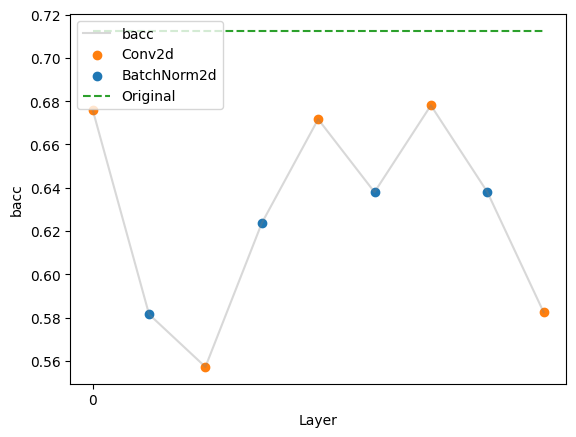

In [4]:
plot_results(results, layers, "bacc")  # loss, acc, miou, bacc

* Short Conv module is very robust to injection
* BatchNorm2d is slightly less robust to injection than Conv2d

## Intermediate Output Statistics

In [ ]:
%load_ext autoreload
%autoreload 2

import json
import pandas as pd

from utils.utils import get_parser, parse_args, get_layer_type, plot_intermediate_stats
from utils.models.ghostnetv2 import (
    ghostnetv2,
    SegmentationHeadGhostBN,
    GhostNetSS,
)

parser, config_parser = get_parser()
args = parse_args(parser, config_parser, args="", verbose=False)

In [ ]:
# Define the model
backbone = ghostnetv2(
    args=args,
)
head = SegmentationHeadGhostBN(args=args)
model = GhostNetSS(backbone, head, args=args)
# model = load_fi_weights(model, args.ckpt).cuda()

In [ ]:
# Original model stats
results = json.load(open(f"ckpt/{args.exp.replace('iTrue','iFalse')}_stats.json", "r"))
results = pd.DataFrame.from_dict(
    results, orient="index", columns=["mean", "std", "min", "max"]
)
llist = [get_layer_type(model, layer) for layer in results.index]
results["name"] = results.index
results["layer_type"] = llist
results.reset_index(drop=True, inplace=True)

In [ ]:
# Fault injected model stats
fresults = json.load(open(f"ckpt/{args.exp.replace('iFalse','iTrue')}_stats.json", "r"))
fresults = pd.DataFrame.from_dict(
    fresults, orient="index", columns=["mean", "std", "min", "max"]
)
llist = [get_layer_type(model, layer) for layer in fresults.index]
fresults["name"] = fresults.index
fresults["layer_type"] = llist
fresults.reset_index(drop=True, inplace=True)

In [ ]:
plot_intermediate_stats(
    results=results, fresults=fresults, per_layer=True, ylim=None, log=True, alpha=0.5
)

- Conv: -
- Linear: -
- BN: ClipBN (min, max) -> 0 or (min, max) (or 10x)
- Activation: ClipAct (min, max) -> 0 or (min, max) (or 10x)
- AvgPool: ClipAvgPool2d (min, max) -> 0 or (min, max) (or 10x)

# _misc

### Import .tif

In [ ]:
# From TIF file to numpy array

import numpy as np
import rasterio

img_path = "data/2021-09-01T10-00-00Z.tif"

# Open the images using rasterio
with rasterio.open(img_path) as img:
    b02 = img.read(2)  # Band 2 = Blue
    b03 = img.read(3)  # Band 3 = Green
    b04 = img.read(4)  # Band 4 = Red
    b08 = img.read(8)  # Band 8 = NIR
    b11 = img.read(11)  # Band 11 = SWIR1

    # Stack the bands
    img_image = np.stack([b02, b03, b04, b08, b11], axis=0).astype(np.float32)
# From TIF file to numpy array

import numpy as np
import rasterio

img_path = "data/2021-09-01T10-00-00Z.tif"

# Open the images using rasterio
with rasterio.open(img_path) as img:
    b02 = img.read(2)  # Band 2 = Blue
    b03 = img.read(3)  # Band 3 = Green
    b04 = img.read(4)  # Band 4 = Red
    b08 = img.read(8)  # Band 8 = NIR
    b11 = img.read(11)  # Band 11 = SWIR1

    # Stack the bands
    img_image = np.stack([b02, b03, b04, b08, b11], axis=0).astype(np.float32)

### Update faulty_idxs

In [ ]:
import torch

BS = 4
faulty_idxs = -torch.ones(BS)

In [ ]:
sampled_indexes = torch.randint(0, 2, (BS,))
cnt = 99

In [ ]:
faulty_idxs, sampled_indexes

In [ ]:
faulty_idxs += (faulty_idxs < 0) * sampled_indexes * (cnt + 1)

### Multithreading

In [ ]:
import itertools
from concurrent.futures import ThreadPoolExecutor
from time import sleep, time


def do_something(number, string, boolean):
    sleep(1)  # Simulate a long task
    return f"{number} {string} {boolean}"

In [ ]:
# Prep
level_1 = [1, 2, 3]
level_2 = ["a", "b", "c"]
level_3 = [True, False]
start = time()

# Define a thread pool with 3 workers
with ThreadPoolExecutor(max_workers=3) as executor:

    # This can be a list comprehension, but I'm using a for loop for clarity
    # Itertools is used to squash the 3 lists into a single iterable of tuples
    # whose elements are the arguments for the function
    futures = []
    for args in itertools.product(level_1, level_2, level_3):
        futures.append(executor.submit(do_something, *args))

    # Note: in production code, you'd use a timeout and handle timeout exceptions
    # to avoid blocking indefinitely
    results = [future.result() for future in futures]

# Print results
end = time()
print("Results:", results)
print("Time:", end - start)

In [ ]:
# Prep
level_1 = [1, 2, 3]
level_2 = ["a", "b", "c"]
level_3 = [True, False]
start = time()

for n in level_1:
    for s in level_2:
        for b in level_3:
            do_something(n, s, b)

# Print results
end = time()
print("Results:", results)
print("Time:", end - start)

### Sentinel Data

In [ ]:
import mlstac

mlstac.download(
    snippet="isp-uv-es/CloudSEN12Plus", path="data", split="validation", quiet=True
)  # use "all" to download the entire dataset
# Load the ML-STAC collection
ds = mlstac.load(snippet="data/main.json")

In [ ]:
ds.metadata["split"].unique()  # ['train', 'validation', 'test']

In [ ]:
ds.metadata[
    (ds.metadata["split"] == "validation")
    & (ds.metadata["label_type"] == "high")
    & (ds.metadata["proj_shape"] == 509)
]

In [ ]:
# Load the metadata from the MLSTAC Collection file
metadata = mlstac.load(snippet="data/main.json").metadata

# Split the metadata into train, validation and test sets
train_dataset = metadata[
    (metadata["split"] == "validation")
    & (metadata["label_type"] == "high")
    & (metadata["proj_shape"] == 509)
]

sample = mlstac.get_data(dataset=train_dataset.iloc[0], quiet=True).squeeze()

In [ ]:
sample.shape